In [3]:
import os
import pandas as pd
import pickle

pkl_folder_path = "/content/fraud_data/data/"
dataframes = []

for file in os.listdir(pkl_folder_path):
    if file.endswith('.pkl'):
        try:
            with open(os.path.join(pkl_folder_path, file), 'rb') as f:
                obj = pickle.load(f)
                if isinstance(obj, pd.DataFrame):
                    dataframes.append(obj)
        except Exception as e:
            print(f"Failed to load {file}: {e}")

print(f"Total DataFrames loaded: {len(dataframes)}")

# Combine all loaded DataFrames
full_df = pd.concat(dataframes, ignore_index=True)

# Basic overview
print("Shape:", full_df.shape)
print("Columns:", full_df.columns.tolist())
print(full_df.dtypes)
print(full_df.head())

Total DataFrames loaded: 183
Shape: (1754155, 9)
Columns: ['TRANSACTION_ID', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_FRAUD', 'TX_FRAUD_SCENARIO']
TRANSACTION_ID                int64
TX_DATETIME          datetime64[ns]
CUSTOMER_ID                  object
TERMINAL_ID                  object
TX_AMOUNT                   float64
TX_TIME_SECONDS              object
TX_TIME_DAYS                 object
TX_FRAUD                      int64
TX_FRAUD_SCENARIO             int64
dtype: object
   TRANSACTION_ID         TX_DATETIME CUSTOMER_ID TERMINAL_ID  TX_AMOUNT  \
0          191611 2018-04-21 00:02:27        4332        9641     126.86   
1          191612 2018-04-21 00:03:25        2053        8942      60.74   
2          191613 2018-04-21 00:04:10        2537        7846      63.41   
3          191614 2018-04-21 00:05:15        4606        8701      47.18   
4          191615 2018-04-21 00:05:37         544        6556     139.72   

  

In [4]:
# Convert datetime column
full_df['TX_DATETIME'] = pd.to_datetime(full_df['TX_DATETIME'])

# Extract time-based features
full_df['TX_DAY'] = full_df['TX_DATETIME'].dt.day
full_df['TX_HOUR'] = full_df['TX_DATETIME'].dt.hour
full_df['TX_MONTH'] = full_df['TX_DATETIME'].dt.month

# Drop unused columns
full_df.drop(['TRANSACTION_ID', 'TX_DATETIME'], axis=1, inplace=True)

In [6]:
from sklearn.preprocessing import LabelEncoder

le_customer = LabelEncoder()
le_terminal = LabelEncoder()

full_df['CUSTOMER_ID'] = le_customer.fit_transform(full_df['CUSTOMER_ID'])
full_df['TERMINAL_ID'] = le_terminal.fit_transform(full_df['TERMINAL_ID'])

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = full_df.drop('TX_FRAUD', axis=1)
y = full_df['TX_FRAUD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    347922
           1       1.00      1.00      1.00      2909

    accuracy                           1.00    350831
   macro avg       1.00      1.00      1.00    350831
weighted avg       1.00      1.00      1.00    350831



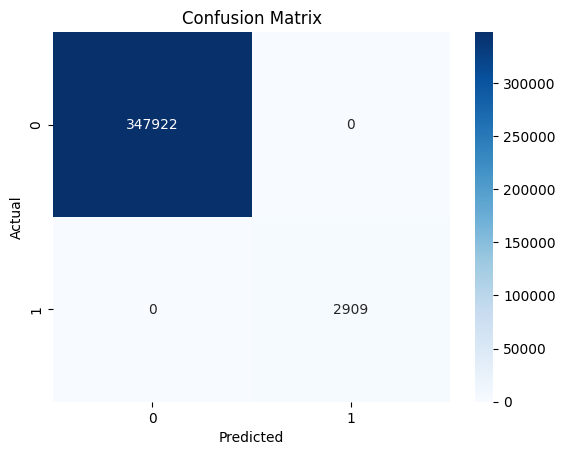

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Prediction on sample input data

In [11]:
# Pick a real fraudulent transaction
fraud_sample = full_df[full_df['TX_FRAUD'] == 1].iloc[0:1]

# Separate features from label
fraud_features = fraud_sample.drop('TX_FRAUD', axis=1)

# Scale it using the loaded scaler
fraud_scaled = scaler_loaded.transform(fraud_features)

# Predict using the trained model
prediction = model_loaded.predict(fraud_scaled)[0]
proba = model_loaded.predict_proba(fraud_scaled)[0]

print("Prediction:", "Fraud" if prediction == 1 else "Legit")
print("Probability of Fraud:", round(proba[1], 4))
print("Probability of Legit:", round(proba[0], 4))

Prediction: Fraud
Probability of Fraud: 1.0
Probability of Legit: 0.0
